# Deep Learning Grid Search

In this project, we will learn how to use the scikit-learn grid search capability.

We are going to learn the following topics:

* How to use Keras models in scikit-learn.
* How to use grid search in scikit-learn.
* How to tune batch size and training epochs.
* How to tune learning rate
* How to tune network weight initialization.
* How to tune activation functions.
* How to tune dropout regularization.
* How to tune the number of neurons in the hidden layer.

In [1]:
import sys
import pandas
import numpy
import sklearn
import keras

print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pandas.__version__))
print('Numpy: {}'.format(numpy.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
Pandas: 0.23.4
Numpy: 1.16.2
Sklearn: 0.20.3
Keras: 2.2.4


In [2]:
import pandas as pd
import numpy as np

names = ['n_pregnant', 'glucose_concentration', 'blood_pressuer (mm Hg)', 'skin_thickness (mm)', 'serum_insulin (mu U/ml)',
        'BMI', 'pedigree_function', 'age', 'class']
#df = pd.read_csv('../input/diabetes.csv', names = names)
df = pd.read_csv('../input/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Describe the dataset
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df[df['Glucose'] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [5]:
# Preprocess the data, mark zero values as NaN and drop
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns:
    df[col].replace(0, np.NaN, inplace=True)
    
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Drop rows with missing values
df.dropna(inplace=True)

# summarize the number of rows and columns in df
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# Convert dataframe to numpy array
dataset = df.values
print(dataset.shape)

(392, 9)


In [8]:
# split into input (X) and an output (Y)
X = dataset[:,0:8]
Y = dataset[:, 8].astype(int)

In [9]:
print(X.shape)
print(Y.shape)
print(Y[:5])

(392, 8)
(392,)
[0 1 1 1 1]


In [10]:
# Normalize the data using sklearn StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)

In [11]:
print(scaler)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [12]:
# Transform and display the training data
X_standardized = scaler.transform(X)

data = pd.DataFrame(X_standardized)
data.describe()

,0,1,2,3,4,5,6,7
count,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02
mean,-4.021726e-17,3.129583e-17,-4.641624e-16,1.042250e-16,6.485742e-17,1.543550e-16,3.880116e-17,1.028089e-16
std,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00
min,-1.029213e+00,-2.161731e+00,-3.739001e+00,-2.108484e+00,-1.196867e+00,-2.120941e+00,-1.269525e+00,-9.682991e-01
25%,-7.174265e-01,-7.665958e-01,-6.941640e-01,-7.755315e-01,-6.681786e-01,-6.676780e-01,-7.340909e-01,-7.719850e-01
50%,-4.056403e-01,-1.176959e-01,-5.314565e-02,-1.384444e-02,-2.574448e-01,1.621036e-02,-2.131475e-01,-3.793569e-01
75%,5.297185e-01,6.609841e-01,5.878727e-01,7.478426e-01,2.859877e-01,5.718696e-01,4.751644e-01,5.040564e-01
max,4.271153e+00,2.445459e+00,3.151946e+00,3.223325e+00,5.812990e+00,4.846172e+00,5.497667e+00,4.921123e+00


In [13]:
# import necessary sklearn and keras packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

# Do a grid search for the optimal batch size and number of epochs
# import necessary packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [14]:

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, input_dim = 16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, verbose = 0)

# define the grid search parameters
batch_size = [16, 32, 64,128]
epochs = [2, 5, 10]

# make a dictionary of the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] batch_size=16, epochs=2 .........................................
Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Use tf.cast instead.
[CV]  batch_size=16, epochs=2, score=0.7251908396946565, total=   4.6s
[CV] batch_size=16, epochs=2 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  batch_size=16, epochs=2, score=0.6946564885496184, total=   1.0s
[CV] batch_size=16, epochs=2 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV] ............... batch_size=16, epochs=2, score=0.8, total=   1.1s
[CV] batch_size=16, epochs=5 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  batch_size=16, epochs=5, score=0.7251908396946565, total=   1.4s
[CV] batch_size=16, epochs=5 .........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.2s remaining:    0.0s


[CV]  batch_size=16, epochs=5, score=0.7557251908396947, total=   1.4s
[CV] batch_size=16, epochs=5 .........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s remaining:    0.0s


[CV] . batch_size=16, epochs=5, score=0.823076923076923, total=   1.4s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.0s remaining:    0.0s


[CV]  batch_size=16, epochs=10, score=0.7251908396946565, total=   1.9s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.9s remaining:    0.0s


[CV]  batch_size=16, epochs=10, score=0.7633587786259542, total=   1.8s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.7s remaining:    0.0s


[CV]  batch_size=16, epochs=10, score=0.823076923076923, total=   2.0s
[CV] batch_size=32, epochs=2 .........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.8s remaining:    0.0s


[CV]  batch_size=32, epochs=2, score=0.6106870229007634, total=   1.5s
[CV] batch_size=32, epochs=2 .........................................
[CV]  batch_size=32, epochs=2, score=0.7175572519083969, total=   1.7s
[CV] batch_size=32, epochs=2 .........................................
[CV]  batch_size=32, epochs=2, score=0.7076923076923077, total=   1.6s
[CV] batch_size=32, epochs=5 .........................................
[CV]  batch_size=32, epochs=5, score=0.7480916030534351, total=   2.0s
[CV] batch_size=32, epochs=5 .........................................
[CV]  batch_size=32, epochs=5, score=0.7633587786259542, total=   2.2s
[CV] batch_size=32, epochs=5 .........................................
[CV]  batch_size=32, epochs=5, score=0.7769230769230769, total=   2.0s
[CV] batch_size=32, epochs=10 ........................................
[CV]  batch_size=32, epochs=10, score=0.7251908396946565, total=   2.4s
[CV] batch_size=32, epochs=10 ........................................
[CV] 

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.6min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.7704081632653061, using {'batch_size': 16, 'epochs': 10}
0.7397959183673469 (0.04420655086038713) with: {'batch_size': 16, 'epochs': 2}
0.7678571428571429 (0.040850475022620486) with: {'batch_size': 16, 'epochs': 5}
0.7704081632653061 (0.04024710335299166) with: {'batch_size': 16, 'epochs': 10}
0.6785714285714286 (0.04826150648308716) with: {'batch_size': 32, 'epochs': 2}
0.7627551020408163 (0.011770576951981667) with: {'batch_size': 32, 'epochs': 5}
0.7602040816326531 (0.03473598863727556) with: {'batch_size': 32, 'epochs': 10}
0.6683673469387755 (0.040922319147141326) with: {'batch_size': 64, 'epochs': 2}
0.7704081632653061 (0.02644777265496764) with: {'batch_size': 64, 'epochs': 5}
0.6683673469387755 (0.040922319147141326) with: {'batch_size': 64, 'epochs': 10}
0.6683673469387755 (0.040922319147141326) with: {'batch_size': 128, 'epochs': 2}
0.6683673469387755 (0.040922319147141326) with: {'batch_size': 128, 'epochs': 5}
0.7346938775510204 (0.09038727439766982) with: {'batch_

In [15]:
best_batch_size = 64
best_epochs = 10 # 100

In [16]:

# Do a grid search for learning rate and dropout rate
# import necessary packages
from keras.layers import Dropout

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(learn_rate, dropout_rate):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, input_dim = 16, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    adam = Adam(lr = learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = best_epochs, batch_size = best_batch_size, verbose = 0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.2, 0.4,0.6]

# make a dictionary of the grid search parameters
param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  dropout_rate=0.0, learn_rate=0.001, score=0.6106870229007634, total=   4.6s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  dropout_rate=0.0, learn_rate=0.001, score=0.6946564885496184, total=   4.8s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV] .... dropout_rate=0.0, learn_rate=0.001, score=0.7, total=   4.7s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s


[CV]  dropout_rate=0.0, learn_rate=0.01, score=0.6106870229007634, total=   5.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.1s remaining:    0.0s


[CV]  dropout_rate=0.0, learn_rate=0.01, score=0.7557251908396947, total=   4.9s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.0s remaining:    0.0s


[CV]  dropout_rate=0.0, learn_rate=0.01, score=0.8076923076923077, total=   5.1s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.1s remaining:    0.0s


[CV]  dropout_rate=0.0, learn_rate=0.1, score=0.7251908396946565, total=   5.4s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   34.6s remaining:    0.0s


[CV]  dropout_rate=0.0, learn_rate=0.1, score=0.7786259541984732, total=   5.3s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   39.9s remaining:    0.0s


[CV]  dropout_rate=0.0, learn_rate=0.1, score=0.8307692307692308, total=   5.5s
[CV] dropout_rate=0.2, learn_rate=0.001 ..............................
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   45.3s remaining:    0.0s


[CV]  dropout_rate=0.2, learn_rate=0.001, score=0.6106870229007634, total=   6.8s
[CV] dropout_rate=0.2, learn_rate=0.001 ..............................
[CV]  dropout_rate=0.2, learn_rate=0.001, score=0.6946564885496184, total=   6.1s
[CV] dropout_rate=0.2, learn_rate=0.001 ..............................
[CV] .... dropout_rate=0.2, learn_rate=0.001, score=0.7, total=   6.4s
[CV] dropout_rate=0.2, learn_rate=0.01 ...............................
[CV]  dropout_rate=0.2, learn_rate=0.01, score=0.7633587786259542, total=   6.2s
[CV] dropout_rate=0.2, learn_rate=0.01 ...............................
[CV]  dropout_rate=0.2, learn_rate=0.01, score=0.6946564885496184, total=   6.5s
[CV] dropout_rate=0.2, learn_rate=0.01 ...............................
[CV]  dropout_rate=0.2, learn_rate=0.01, score=0.8153846153846154, total=   6.8s
[CV] dropout_rate=0.2, learn_rate=0.1 ................................
[CV]  dropout_rate=0.2, learn_rate=0.1, score=0.7175572519083969, total=   6.8s
[CV] dropout_rat

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.5min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.7780612244897959, using {'dropout_rate': 0.0, 'learn_rate': 0.1}
0.6683673469387755 (0.040922319147141326) with: {'dropout_rate': 0.0, 'learn_rate': 0.001}
0.7244897959183674 (0.08336583367699418) with: {'dropout_rate': 0.0, 'learn_rate': 0.01}
0.7780612244897959 (0.04307624211807271) with: {'dropout_rate': 0.0, 'learn_rate': 0.1}
0.6683673469387755 (0.040922319147141326) with: {'dropout_rate': 0.2, 'learn_rate': 0.001}
0.7576530612244898 (0.04942083877650794) with: {'dropout_rate': 0.2, 'learn_rate': 0.01}
0.7627551020408163 (0.04881531660922254) with: {'dropout_rate': 0.2, 'learn_rate': 0.1}
0.6683673469387755 (0.040922319147141326) with: {'dropout_rate': 0.4, 'learn_rate': 0.001}
0.7627551020408163 (0.03677622413898435) with: {'dropout_rate': 0.4, 'learn_rate': 0.01}
0.701530612244898 (0.07189967139719973) with: {'dropout_rate': 0.4, 'learn_rate': 0.1}
0.6683673469387755 (0.040922319147141326) with: {'dropout_rate': 0.6, 'learn_rate': 0.001}
0.6683673469387755 (0.04092231914

In [17]:
best_dropout_rate = 0.0
best_learn_rate = 0.01

In [18]:

# Do a grid search to optimize kernel initialization and activation functions
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(activation, init):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(16, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(8, input_dim = 16, kernel_initializer= init, activation= activation))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    adam = Adam(lr = best_learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = best_epochs, batch_size = best_batch_size, verbose = 0)

# define the grid search parameters
activation = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']

# make a dictionary of the grid search parameters
param_grid = dict(activation = activation, init = init)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] activation=softmax, init=uniform ................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=softmax, init=uniform, score=0.6106870229007634, total=  10.8s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV]  activation=softmax, init=uniform, score=0.6946564885496184, total=  11.0s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s


[CV] ...... activation=softmax, init=uniform, score=0.7, total=  10.9s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.7s remaining:    0.0s


[CV]  activation=softmax, init=normal, score=0.6106870229007634, total=  11.4s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.1s remaining:    0.0s


[CV]  activation=softmax, init=normal, score=0.6946564885496184, total=  11.3s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.4s remaining:    0.0s


[CV] ....... activation=softmax, init=normal, score=0.7, total=  11.4s
[CV] activation=softmax, init=zero ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  activation=softmax, init=zero, score=0.6106870229007634, total=  12.1s
[CV] activation=softmax, init=zero ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  activation=softmax, init=zero, score=0.6946564885496184, total=  11.8s
[CV] activation=softmax, init=zero ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV] ......... activation=softmax, init=zero, score=0.7, total=  12.1s
[CV] activation=relu, init=uniform ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  activation=relu, init=uniform, score=0.7251908396946565, total=  12.0s
[CV] activation=relu, init=uniform ...................................
[CV]  activation=relu, init=uniform, score=0.7633587786259542, total=  12.1s
[CV] activation=relu, init=uniform ...................................
[CV]  activation=relu, init=uniform, score=0.8076923076923077, total=  12.9s
[CV] activation=relu, init=normal ....................................
[CV]  activation=relu, init=normal, score=0.6106870229007634, total=  13.5s
[CV] activation=relu, init=normal ....................................
[CV]  activation=relu, init=normal, score=0.7557251908396947, total=  13.0s
[CV] activation=relu, init=normal ....................................
[CV]  activation=relu, init=normal, score=0.8076923076923077, total=  13.1s
[CV] activation=relu, init=zero ......................................
[CV]  activation=relu, init=zero, score=0.6106870229007634, total=  13.4s
[CV] activation=relu, init=zero .........

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.2min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.7882653061224489, using {'activation': 'linear', 'init': 'normal'}
0.6683673469387755 (0.040922319147141326) with: {'activation': 'softmax', 'init': 'uniform'}
0.6683673469387755 (0.040922319147141326) with: {'activation': 'softmax', 'init': 'normal'}
0.6683673469387755 (0.040922319147141326) with: {'activation': 'softmax', 'init': 'zero'}
0.7653061224489796 (0.03368761076185709) with: {'activation': 'relu', 'init': 'uniform'}
0.7244897959183674 (0.08336583367699418) with: {'activation': 'relu', 'init': 'normal'}
0.6683673469387755 (0.040922319147141326) with: {'activation': 'relu', 'init': 'zero'}
0.7780612244897959 (0.02790754909626552) with: {'activation': 'tanh', 'init': 'uniform'}
0.7831632653061225 (0.028799589930051463) with: {'activation': 'tanh', 'init': 'normal'}
0.6683673469387755 (0.040922319147141326) with: {'activation': 'tanh', 'init': 'zero'}
0.7857142857142857 (0.02181171876613515) with: {'activation': 'linear', 'init': 'uniform'}
0.7882653061224489 (0.03535836

In [19]:
best_activation = 'relu'
best_init = 'normal'

In [20]:

# Do a grid search to find the optimal number of neurons in each hidden layer
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(neuron1, neuron2, neuron3):
    # create model
    model = Sequential()
    model.add(Dense(neuron1, input_dim = 8, kernel_initializer= best_init, activation= best_activation))
    model.add(Dense(neuron2, input_dim = neuron1, kernel_initializer= best_init, activation= best_activation))
    model.add(Dense(neuron3, input_dim = neuron2, kernel_initializer= best_init, activation= best_activation))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    adam = Adam(lr = best_learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = best_epochs, batch_size = best_batch_size, verbose = 0)

# define the grid search parameters
neuron1 = [8, 16, 32]
neuron2 = [16, 32, 64]
neuron3 = [8, 16, 32]

# make a dictionary of the grid search parameters
param_grid = dict(neuron1 = neuron1, neuron2 = neuron2, neuron3 = neuron3)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), refit = True, verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] neuron1=8, neuron2=16, neuron3=8 ................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  neuron1=8, neuron2=16, neuron3=8, score=0.6106870229007634, total=  18.7s
[CV] neuron1=8, neuron2=16, neuron3=8 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=8, score=0.7251908396946565, total=  17.4s
[CV] neuron1=8, neuron2=16, neuron3=8 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.1s remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=8, score=0.7692307692307693, total=  18.1s
[CV] neuron1=8, neuron2=16, neuron3=16 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   54.3s remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=16, score=0.6106870229007634, total=  17.7s
[CV] neuron1=8, neuron2=16, neuron3=16 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=16, score=0.7557251908396947, total=  17.7s
[CV] neuron1=8, neuron2=16, neuron3=16 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=16, score=0.7923076923076923, total=  18.4s
[CV] neuron1=8, neuron2=16, neuron3=32 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=32, score=0.7633587786259542, total=  18.1s
[CV] neuron1=8, neuron2=16, neuron3=32 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.1min remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=32, score=0.7633587786259542, total=  18.4s
[CV] neuron1=8, neuron2=16, neuron3=32 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s


[CV]  neuron1=8, neuron2=16, neuron3=32, score=0.8076923076923077, total=  19.1s
[CV] neuron1=8, neuron2=32, neuron3=8 ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.7min remaining:    0.0s


[CV]  neuron1=8, neuron2=32, neuron3=8, score=0.7251908396946565, total=  19.0s
[CV] neuron1=8, neuron2=32, neuron3=8 ................................
[CV]  neuron1=8, neuron2=32, neuron3=8, score=0.7480916030534351, total=  18.9s
[CV] neuron1=8, neuron2=32, neuron3=8 ................................
[CV]  neuron1=8, neuron2=32, neuron3=8, score=0.8307692307692308, total=  18.9s
[CV] neuron1=8, neuron2=32, neuron3=16 ...............................
[CV]  neuron1=8, neuron2=32, neuron3=16, score=0.7099236641221374, total=  19.9s
[CV] neuron1=8, neuron2=32, neuron3=16 ...............................
[CV]  neuron1=8, neuron2=32, neuron3=16, score=0.7404580152671756, total=  19.6s
[CV] neuron1=8, neuron2=32, neuron3=16 ...............................
[CV]  neuron1=8, neuron2=32, neuron3=16, score=0.7692307692307693, total=  19.4s
[CV] neuron1=8, neuron2=32, neuron3=32 ...............................
[CV]  neuron1=8, neuron2=32, neuron3=32, score=0.732824427480916, total=  20.4s
[CV] neuron

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 34.8min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.7882653061224489, using {'neuron1': 32, 'neuron2': 32, 'neuron3': 8}
0.701530612244898 (0.06682008586082107) with: {'neuron1': 8, 'neuron2': 16, 'neuron3': 8}
0.7193877551020408 (0.07844309477335479) with: {'neuron1': 8, 'neuron2': 16, 'neuron3': 16}
0.7780612244897959 (0.020872215902292657) with: {'neuron1': 8, 'neuron2': 16, 'neuron3': 32}
0.7678571428571429 (0.045293368925678076) with: {'neuron1': 8, 'neuron2': 32, 'neuron3': 8}
0.7397959183673469 (0.024200946643080434) with: {'neuron1': 8, 'neuron2': 32, 'neuron3': 16}
0.7704081632653061 (0.048038433413990944) with: {'neuron1': 8, 'neuron2': 32, 'neuron3': 32}
0.7168367346938775 (0.07540617928767147) with: {'neuron1': 8, 'neuron2': 64, 'neuron3': 8}
0.7780612244897959 (0.021785230619216014) with: {'neuron1': 8, 'neuron2': 64, 'neuron3': 16}
0.7653061224489796 (0.05237424486619331) with: {'neuron1': 8, 'neuron2': 64, 'neuron3': 32}
0.7755102040816326 (0.0462414881823877) with: {'neuron1': 16, 'neuron2': 16, 'neuron3': 8}
0.7

In [21]:
best_neuron1 = 16
best_neuron2 = 16
best_neuron3 = 8

In [22]:
from sklearn.model_selection import train_test_split
#best model
model = Sequential()
model.add(Dense(best_neuron1, input_dim = 8, kernel_initializer= best_init, activation= best_activation))
model.add(Dense(best_neuron2, input_dim = best_neuron1, kernel_initializer= best_init, activation= best_activation))
model.add(Dense(best_neuron3, input_dim = best_neuron2, kernel_initializer= best_init, activation= best_activation))
model.add(Dense(1, activation='sigmoid'))

In [23]:
# compile the model
adam = Adam(lr = best_learn_rate)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
ckpt_model = 'pima-weights_best_t.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_acc', 
                            verbose=1,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

print(X_train.shape)
print(X_test.shape)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    nb_epoch=best_epochs,
                    batch_size=best_batch_size,
                    callbacks=callbacks_list,
                    verbose=1)

(313, 8)
(79, 8)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 313 samples, validate on 79 samples
Epoch 1/10
313/313 [==============================] - 26s 84ms/step - loss: 0.6584 - acc: 0.6645 - val_loss: 0.6114 - val_acc: 0.6709

Epoch 00001: val_acc improved from -inf to 0.67089, saving model to pima-weights_best_t.hdf5
Epoch 2/10
313/313 [==============================] - 0s 190us/step - loss: 0.6138 - acc: 0.6709 - val_loss: 0.6335 - val_acc: 0.6962

Epoch 00002: val_acc improved from 0.67089 to 0.69620, saving model to pima-weights_best_t.hdf5
Epoch 3/10
313/313 [==============================] - 0s 172us/step - loss: 0.6356 - acc: 0.6422 - val_loss: 0.6397 - val_acc: 0.7215

Epoch 00003: val_acc improved from 0.69620 to 0.72152, saving model to pima-weights_best_t.hdf5
Epoch 4/10
313/313 [==============================] - 0s 176us/step - loss: 0.6318 - acc: 0.6581 - val_loss: 0.5667 - val_acc: 0.6835

Epoch 00004: val_acc did not improve from 0.72152
Epoch 5/10
313/313 [==============================] - 0s 174us/step - loss: 0.60

In [24]:
model.load_weights("pima-weights_best_t.hdf5")

In [25]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.3f%%" % (model.metrics_names[1], scores[1]*100))

acc: 73.418%


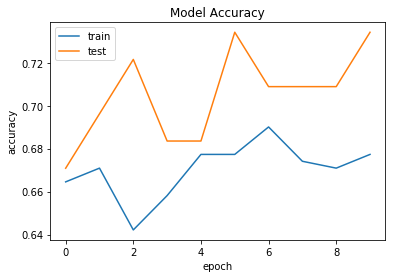

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

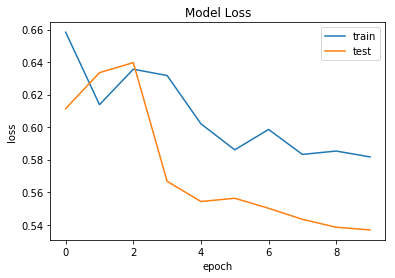

In [27]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

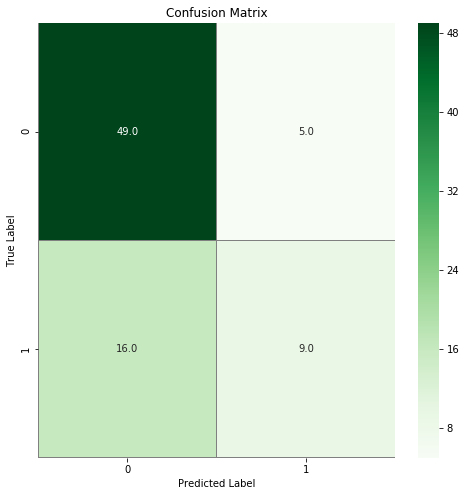

In [28]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
y_final = (y_pred > 0.5).astype(int).reshape(X_test.shape[0])
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.75      0.91      0.82        54
           1       0.64      0.36      0.46        25

   micro avg       0.73      0.73      0.73        79
   macro avg       0.70      0.63      0.64        79
weighted avg       0.72      0.73      0.71        79

